In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/notebooks/processedstopword.csv')

## División de X e y

In [4]:
df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")
df['subject'] = df['subject'].fillna("")

# Extraer características y etiquetas
X = df['text']  # Usaremos el texto del artículo como entrada
y = df['label'] # La variable objetivo

# Convertir el texto en una representación numérica usando TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)  # Limitar a 5000 características para optimización
X_tfidf = vectorizer.fit_transform(X)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

## Regresión Logística

In [5]:

# Entrenar el modelo de Regresión Logística
logreg_model = LogisticRegression(max_iter=500, solver='liblinear')  # Solver optimizado para datos grandes
logreg_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_logreg = logreg_model.predict(X_test)

# Evaluar el modelo
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg)

# Mostrar los resultados
conf_matrix_logreg, class_report_logreg

(array([[4587,   61],
        [  62, 4228]]),
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      4648\n           1       0.99      0.99      0.99      4290\n\n    accuracy                           0.99      8938\n   macro avg       0.99      0.99      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

El modelo indica unos valores muy altos.
- Precisión= 0,99, lo que quiere decir un 99% de precisión 
- f1-score y Recall= Respectivamente estos indicadores muestran que tan bien el modelo encuentra todos los casos de una clase y el balance entre precisión y recall, en nuestro caso un 0,99

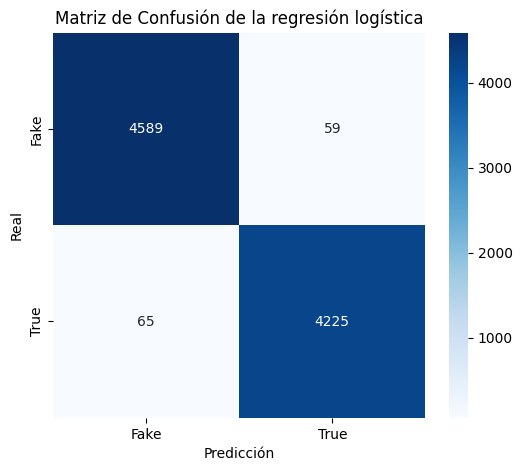

In [15]:
# Definir valores de la matriz de confusión
cm = np.array([[4589, 59],
               [65, 4225]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión de la regresión logística')
plt.show();


Esta matriz de confusión nos indica que nuestro modelo clasifica 4589 fakes cuando son fake, 4225 True cuando son True. 
Por otro lado, se equivoca clasificando Fake cuando es True 65 y True cuando es Fake 59, son valores bastante bajos teniendo en cuenta el tamaño de la muestra 

la regresión logística tiene una precisión muy alta de un 0,99, por lo que voy a comprobar si tiene overfitting

In [14]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

# 5. Evaluación del modelo
# Predicciones
y_train_pred_proba = logreg_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_proba = logreg_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba
y_test_pred = logreg_model.predict(X_test)

# Cálculo de log loss
log_loss_train = log_loss(y_train, y_train_pred_proba)
log_loss_test = log_loss(y_test, y_test_pred_proba)

log_loss_train, log_loss_test

(0.06175222933010205, 0.0689247650154716)

La log loss (pérdida logarítmica) es una métrica que mide qué tan bien un modelo de clasificación predice probabilidades en lugar de simplemente etiquetas. Se usa especialmente en modelos de clasificación binaria y multiclase.
La diferencia en nuestro caso es muy pequeña (0,0072) lo que indica que nuestro modelo genera bien y no causa overfitting


## XG-Boost

In [20]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric='logloss',   # Métrica de evaluación
    use_label_encoder=False, # Evita el warning innecesario
    max_depth=6,             # Controla la complejidad del modelo
    learning_rate=0.1,       # Tasa de aprendizaje equilibrada
    n_estimators=300,        # Aumenta el número de árboles para mejorar el ajuste
    subsample=0.8,           # Reduce overfitting usando solo el 80% de los datos por árbol
    colsample_bytree=0.8,    # Usa el 80% de las características en cada árbol
    gamma=0.1,               # Ayuda a la regularización
    reg_lambda=1,            # Regularización L2 para evitar overfitting
    reg_alpha=0.1            # Regularización L1
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb, digits=4)

# Mostrar los resultados
conf_matrix, class_report


/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:37:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(array([[4636,   12],
        [  11, 4279]]),
 '              precision    recall  f1-score   support\n\n           0     0.9976    0.9974    0.9975      4648\n           1     0.9972    0.9974    0.9973      4290\n\n    accuracy                         0.9974      8938\n   macro avg     0.9974    0.9974    0.9974      8938\nweighted avg     0.9974    0.9974    0.9974      8938\n')

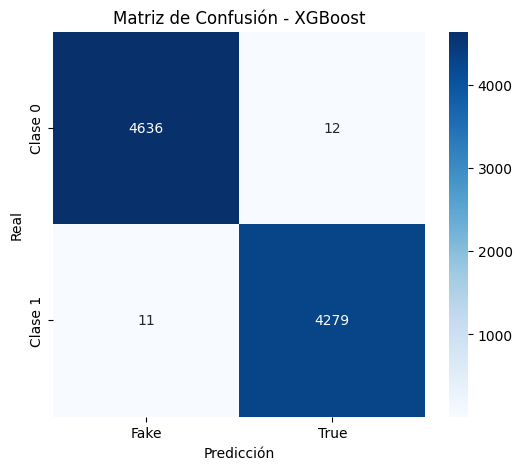

/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learni

(np.float64(0.9965315549013652), np.float64(0.0012796814234147282))

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap([[4636, 12], [11, 4279]], annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# Evaluación de overfitting usando validación cruzada
cv_scores = cross_val_score(xgb_model, X_tfidf, y, cv=5, scoring='accuracy')

# Mostrar los resultados de validación cruzada
cv_scores.mean(), cv_scores.std()


Alta precisión en validación cruzada (99.65%)
El modelo es consistentemente preciso en diferentes subconjuntos de los datos.
Si hubiera overfitting, esperaríamos una caída más pronunciada en los datos de validación.
Baja variabilidad entre folds (0.0013)
La desviación estándar es muy pequeña (0.13%), lo que indica que el modelo es estable y generaliza bien en diferentes subconjuntos.
Si la desviación estándar fuera alta (>2-3%), el modelo sería inconsistente.


In [22]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probaxgb = xgb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probaxgb = xgb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train = log_loss(y_train, y_train_pred_probaxgb)
log_loss_test = log_loss(y_test, y_test_pred_probaxgb)

# Mostrar los resultados
log_loss_train, log_loss_test


(0.000626033891097849, 0.01042879662543264)

El log loss en entrenamiento es extremadamente bajo (0.0006), lo que indica que el modelo memoriza muy bien los datos de entrenamiento.
El log loss en prueba es un poco mayor (0.0104), pero sigue siendo muy bajo.
La diferencia entre ambos (0.0098) es pequeña, lo que sugiere que no hay un overfitting grave.
El modelo generaliza bien, ya que la diferencia entre entrenamiento y prueba no es demasiado grande.

El modelo no tiene un problema grave de overfitting. La validación cruzada confirma que el modelo generaliza bien.

## Gradient boosting

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

# Mostrar los resultados
conf_matrix_gb, class_report_gb

(array([[4617,   31],
        [  14, 4276]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.99      1.00      4648\n           1       0.99      1.00      0.99      4290\n\n    accuracy                           0.99      8938\n   macro avg       0.99      1.00      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

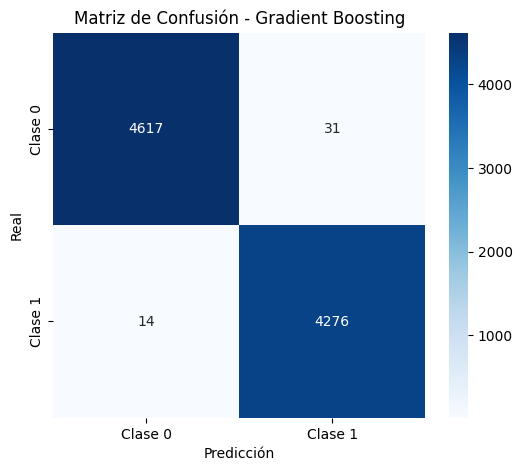

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la matriz de confusión para Gradient Boosting
plt.figure(figsize=(6, 5))
sns.heatmap([[4617, 31], [14, 4276]], annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()


## NP-Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
# Entrenamiento
model = MultinomialNB()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4395  253]
 [ 295 3995]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4648
           1       0.94      0.93      0.94      4290

    accuracy                           0.94      8938
   macro avg       0.94      0.94      0.94      8938
weighted avg       0.94      0.94      0.94      8938



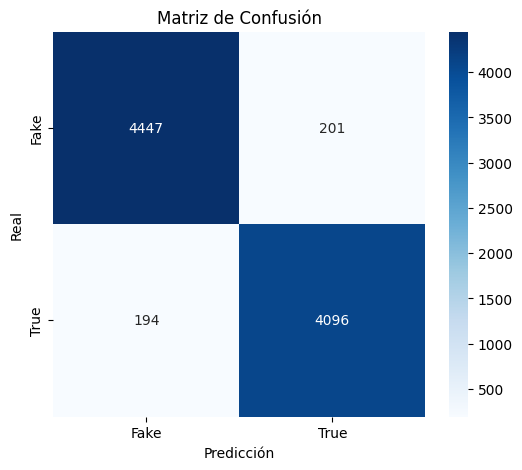

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Definir valores de la matriz de confusión
cm = np.array([[4447, 201],
               [194, 4096]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show();


# Random Forest


In [10]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Mostrar los resultados
conf_matrix_rf, class_report_rf


(array([[4639,    9],
        [  12, 4278]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4648\n           1       1.00      1.00      1.00      4290\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

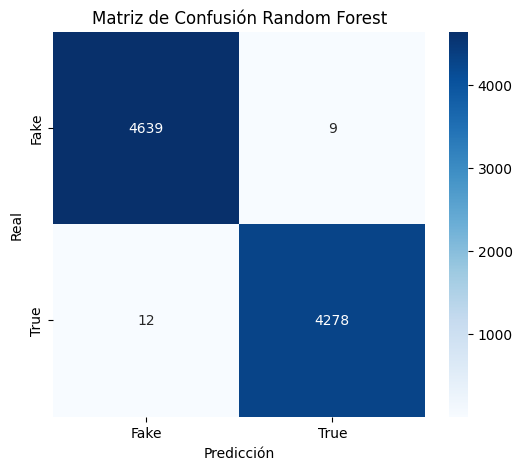

In [11]:
# Definir valores de la matriz de confusión
cm = np.array([[4639, 9],
               [12, 4278]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Random Forest')
plt.show();


## Supervector Machine

In [12]:
from sklearn.svm import SVC
# Entrenar el modelo SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test)

# Evaluar el modelo
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)

# Mostrar los resultados
conf_matrix_svm, class_report_svm

(array([[4620,   28],
        [  43, 4247]]),
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      4648\n           1       0.99      0.99      0.99      4290\n\n    accuracy                           0.99      8938\n   macro avg       0.99      0.99      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

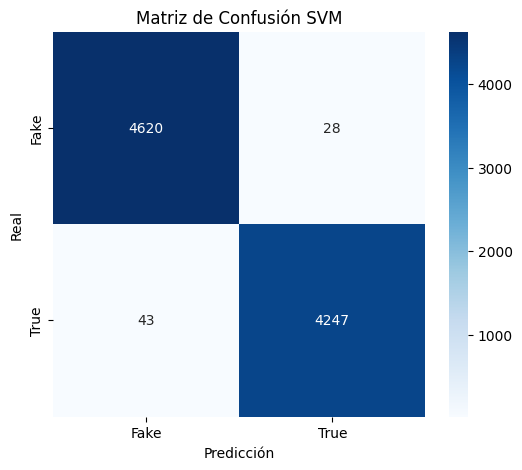

In [13]:
# Definir valores de la matriz de confusión
cm = np.array([[4620, 28],
               [43, 4247]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión SVM')
plt.show();
